# EDA and Feature Engineering for Meta Data
## Import necessary libraries

In [1]:
# Python libraries
import datetime as dt
import re
import pickle
from tqdm.notebook import tqdm
import os
import sys
from collections import defaultdict
from collections import Counter

# Data Science modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
plt.style.use('ggplot')
sns.set(style='white', context='notebook', palette='deep')

## Load preprocessed data

In [2]:
# Load nontext data
file = open('../data/preprocessed/nontext_data.pickle', 'rb')
nontext_data = pickle.load(file)
file.close()

print(nontext_data.shape)
nontext_data.head()

(403, 49)


,unscheduled,forecast,confcall,ChairPerson,Rate,RateDiff,RateDecision,RateChanged,GDP_date,GDP_value,...,Hsales_diff_year,Taylor,Balanced,Inertia,Taylor-Rate,Balanced-Rate,Inertia-Rate,Taylor_diff,Balanced_diff,Inertia_diff
date,,,,,,,,,,,,,,,,,,,,,
1982-10-05,False,False,False,Paul Volcker,9.5,-0.5,-1,1,1982-04-01,7328.912,...,42.307692,11.061999,11.567540,6.764869,1.061999,1.567540,-3.235131,NaN,NaN,NaN
1982-11-16,False,False,False,Paul Volcker,9.0,-0.5,-1,1,1982-07-01,7300.896,...,34.831461,10.045779,9.987419,6.576887,0.545779,0.487419,-2.923113,-1.016220,-1.580121,-0.187982
1982-12-21,False,False,False,Paul Volcker,8.5,0.0,0,0,1982-07-01,7300.896,...,45.026178,10.105638,10.047278,5.717908,1.605638,1.547278,-2.782092,0.059859,0.059859,-0.858979
1983-01-14,False,False,True,Paul Volcker,8.5,0.0,0,0,1982-07-01,7300.896,...,14.004376,9.766001,9.707641,5.768854,1.266001,1.207641,-2.731146,-0.339637,-0.339637,0.050946
1983-01-21,False,False,True,Paul Volcker,8.5,0.0,0,0,1982-07-01,7300.896,...,14.004376,9.766001,9.707641,5.768854,1.266001,1.207641,-2.731146,0.000000,0.000000,0.000000


In [3]:
# Load nontext moving average data
file = open('../data/preprocessed/nontext_ma2.pickle', 'rb')
nontext_ma2 = pickle.load(file)
file.close()
file = open('../data/preprocessed/nontext_ma3.pickle', 'rb')
nontext_ma3 = pickle.load(file)
file.close()
file = open('../data/preprocessed/nontext_ma6.pickle', 'rb')
nontext_ma6 = pickle.load(file)
file.close()
file = open('../data/preprocessed/nontext_ma12.pickle', 'rb')
nontext_ma12 = pickle.load(file)
file.close()

# EDA on nontext dataset

In [4]:
# Add previous rate decision to see inertia effect
nontext_data['prev_decision'] = nontext_data['RateDecision'].shift(1)
nontext_data['next_decision'] = nontext_data['RateDecision'].shift(-1)
nontext_data[['RateDecision', 'prev_decision', 'next_decision']].head()

,RateDecision,prev_decision,next_decision
date,,,
1982-10-05,-1,<NA>,-1
1982-11-16,-1,-1,0
1982-12-21,0,-1,0
1983-01-14,0,0,0
1983-01-21,0,0,0


In [5]:
# # Take the same period as text dataset (--> Removed as it is determined later)
# nontext_data = nontext_data.loc[nontext_data.index > dt.datetime(1994,1,1)]
# nontext_ma2 = nontext_ma2.loc[nontext_ma2.index > dt.datetime(1994,1,1)]
# nontext_ma3 = nontext_ma3.loc[nontext_ma3.index > dt.datetime(1994,1,1)]
# nontext_ma6 = nontext_ma6.loc[nontext_ma6.index > dt.datetime(1994,1,1)]
# nontext_ma12 = nontext_ma12.loc[nontext_ma12.index > dt.datetime(1994,1,1)]

In [6]:
nontext_data.describe()

,Rate,RateDiff,RateDecision,RateChanged,GDP_date,GDP_value,GDP_diff_prev,GDP_diff_year,GDPPOT_date,GDPPOT_value,...,Balanced,Inertia,Taylor-Rate,Balanced-Rate,Inertia-Rate,Taylor_diff,Balanced_diff,Inertia_diff,prev_decision,next_decision
count,403.000000,403.000000,403.0,403.000000,403,403.000000,403.000000,403.000000,403,403.000000,...,403.000000,403.000000,403.000000,403.000000,403.000000,402.000000,402.000000,402.000000,402.0,402.0
mean,4.123139,-0.013648,-0.002481,0.349876,2000-08-25 16:11:54.640198528,13743.566759,0.670809,2.579228,2000-08-25 16:11:54.640198528,12943.390125,...,10.843125,1.888745,3.788570,6.707579,-2.246801,-0.001489,0.008153,-0.011266,-0.002488,0.0
min,0.000000,-1.000000,-1.0,0.000000,1982-04-01 00:00:00,7300.896000,-7.891020,-7.528460,1982-04-01 00:00:00,7255.183995,...,0.363113,-2.715072,-1.370974,-0.727467,-3.798606,-4.387038,-8.710434,-1.129326,-1.0,-1.0
25%,1.250000,0.000000,0.0,0.000000,1990-11-16 00:00:00,10029.510000,0.406511,1.700868,1990-11-16 00:00:00,9561.882122,...,9.707641,-0.236884,2.172784,5.456855,-2.731146,-0.159465,-0.156235,-0.073845,0.0,0.0
50%,4.500000,0.000000,0.0,0.000000,1999-10-01 00:00:00,13827.980000,0.679082,2.821007,1999-10-01 00:00:00,12599.250241,...,11.185918,1.985703,3.602982,6.579379,-2.375645,0.000000,0.000000,0.000000,0.0,0.0
75%,6.000000,0.000000,0.0,1.000000,2009-07-01 00:00:00,16854.295000,1.016395,3.973172,2009-07-01 00:00:00,16045.761443,...,12.197398,3.463909,5.136048,7.697057,-1.788940,0.134104,0.159078,0.048989,0.0,0.0
max,11.500000,1.125000,1.0,1.000000,2023-07-01 00:00:00,22490.692000,7.759223,11.950272,2023-07-01 00:00:00,20603.700000,...,18.100479,7.836042,13.577360,18.100479,-0.054467,3.975129,7.528842,1.306565,1.0,1.0
std,3.040895,0.243996,0.592233,0.477523,NaN,4189.787375,1.072146,2.156912,NaN,3888.088505,...,2.599051,2.391353,2.222063,2.664022,0.749666,0.475487,0.772148,0.241521,0.592971,0.59087


In [7]:
nontext_data.isnull().sum()

unscheduled           0
forecast              0
confcall              0
ChairPerson           0
Rate                  0
RateDiff              0
RateDecision          0
RateChanged           0
GDP_date              0
GDP_value             0
GDP_diff_prev         0
GDP_diff_year         0
GDPPOT_date           0
GDPPOT_value          0
GDPPOT_diff_prev      0
GDPPOT_diff_year      0
PCE_date              0
PCE_value             0
PCE_diff_prev         0
PCE_diff_year         0
CPI_date              0
CPI_value             0
CPI_diff_prev         0
CPI_diff_year         0
Unemp_date            0
Unemp_value           0
Unemp_diff_prev       0
Unemp_diff_year       0
Employ_date           0
Employ_value          0
Employ_diff_prev      0
Employ_diff_year      0
Rsales_date         116
Rsales_value        116
Rsales_diff_prev    117
Rsales_diff_year    129
Hsales_date           0
Hsales_value          0
Hsales_diff_prev      0
Hsales_diff_year      0
Taylor                0
Balanced        

Count: 
RateDecision
0     262
-1     71
1      70
Name: count, dtype: Int64
Percent: 
RateDecision
0     65.0
-1    18.0
1     17.0
Name: count, dtype: Float64


Text(0.5, 1.0, 'nontext_data')

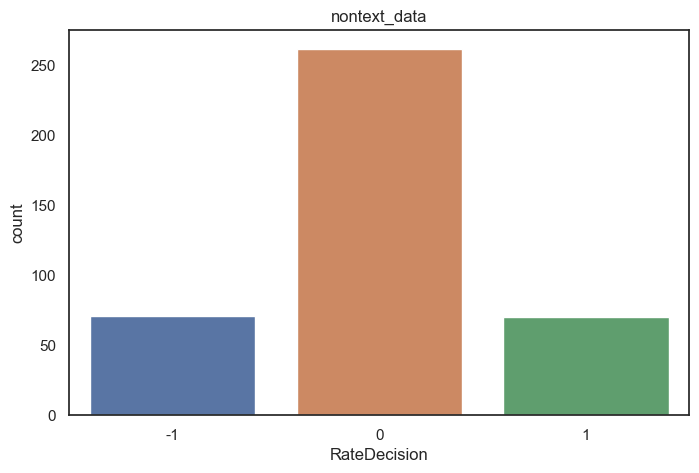

In [8]:
# The number of data per Target Labels
x = nontext_data['RateDecision'].value_counts()
print("Count: ")
print(x)
print("Percent: ")
print(round(x/sum(x) * 100))
# sns.barplot(x.index, x)
# plt.gca().set_ylabel('number of samples')
plt.figure(figsize=(8,5))
ax = sns.countplot(x='RateDecision', data=nontext_data)
ax.set_title('nontext_data')

Highly imbalanced to 0 (hold), so need to consider this point. Always predicting 0 (hold) will result in the accuracy of more than 60%. 

## Correlation

In [9]:
nontext_data.columns.values

array(['unscheduled', 'forecast', 'confcall', 'ChairPerson', 'Rate',
       'RateDiff', 'RateDecision', 'RateChanged', 'GDP_date', 'GDP_value',
       'GDP_diff_prev', 'GDP_diff_year', 'GDPPOT_date', 'GDPPOT_value',
       'GDPPOT_diff_prev', 'GDPPOT_diff_year', 'PCE_date', 'PCE_value',
       'PCE_diff_prev', 'PCE_diff_year', 'CPI_date', 'CPI_value',
       'CPI_diff_prev', 'CPI_diff_year', 'Unemp_date', 'Unemp_value',
       'Unemp_diff_prev', 'Unemp_diff_year', 'Employ_date',
       'Employ_value', 'Employ_diff_prev', 'Employ_diff_year',
       'Rsales_date', 'Rsales_value', 'Rsales_diff_prev',
       'Rsales_diff_year', 'Hsales_date', 'Hsales_value',
       'Hsales_diff_prev', 'Hsales_diff_year', 'Taylor', 'Balanced',
       'Inertia', 'Taylor-Rate', 'Balanced-Rate', 'Inertia-Rate',
       'Taylor_diff', 'Balanced_diff', 'Inertia_diff', 'prev_decision',
       'next_decision'], dtype=object)

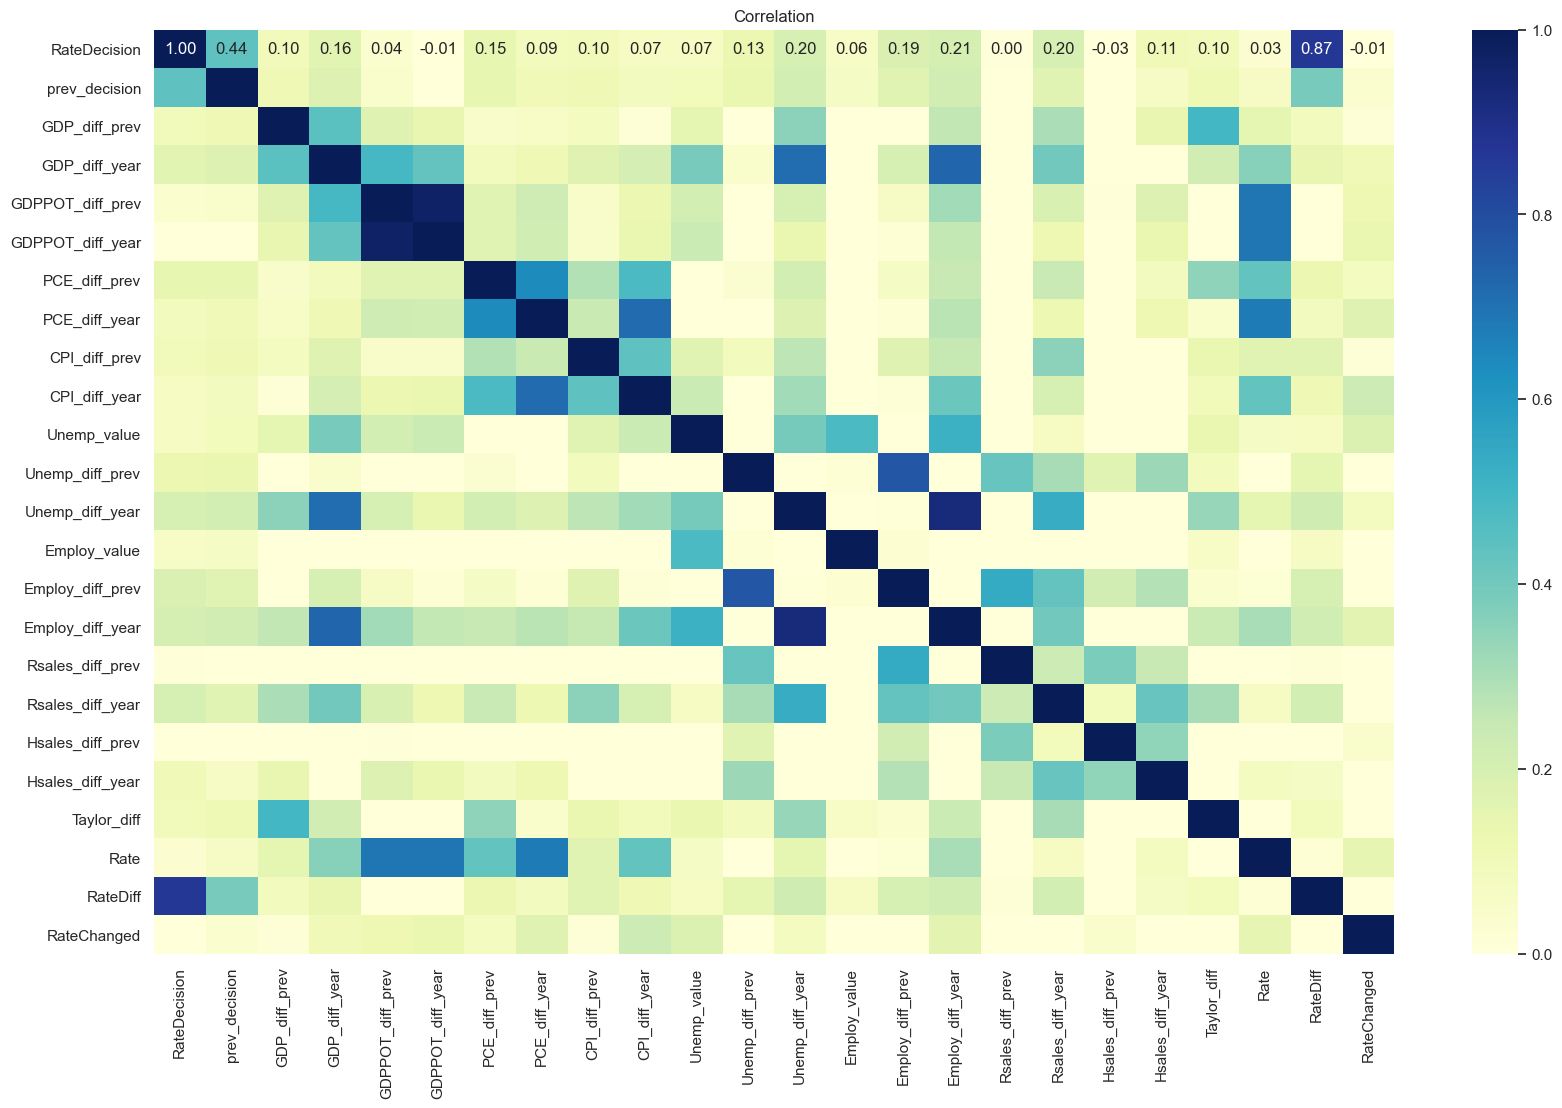

In [11]:
# Per document type
corr_columns = ['RateDecision', 'prev_decision', 
                'GDP_diff_prev', 'GDP_diff_year', 'GDPPOT_diff_prev', 'GDPPOT_diff_year',
                'PCE_diff_prev', 'PCE_diff_year', 'CPI_diff_prev', 'CPI_diff_year', 
                'Unemp_value', 'Unemp_diff_prev', 'Unemp_diff_year',
                'Employ_value', 'Employ_diff_prev', 'Employ_diff_year',
                'Rsales_diff_prev', 'Rsales_diff_year', 'Hsales_diff_prev', 'Hsales_diff_year',
                'Taylor_diff', 'Rate', 'RateDiff', 'RateChanged']

fig, ax = plt.subplots(1, 1, figsize=(20, 12))

sns.heatmap(nontext_data[corr_columns].astype(float).corr(), cmap="YlGnBu", annot=True, fmt=".2f", vmin=0, vmax=1, ax=ax)
ax.set_title("Correlation")
plt.show()

In [12]:
# Calcular la matriz de correlación
correlation_matrix = nontext_data[corr_columns].astype(float).corr()

# Especificar la variable objetivo para la cual deseas obtener la correlación
target_variable = 'RateDecision'

# Obtener las correlaciones con respecto a la variable objetivo y ordenarlas de forma descendente
correlations_with_target = correlation_matrix[target_variable].sort_values(ascending=False)

# Mostrar las correlaciones ordenadas
print("Variables ordenadas por correlación con respecto a", target_variable)
print(correlations_with_target)

Variables ordenadas por correlación con respecto a RateDecision
RateDecision        1.000000
RateDiff            0.866953
prev_decision       0.441288
Employ_diff_year    0.205742
Rsales_diff_year    0.203053
Unemp_diff_year     0.201304
Employ_diff_prev    0.188269
GDP_diff_year       0.160786
PCE_diff_prev       0.145617
Unemp_diff_prev     0.132367
Hsales_diff_year    0.106149
GDP_diff_prev       0.100549
CPI_diff_prev       0.098701
Taylor_diff         0.095670
PCE_diff_year       0.086916
CPI_diff_year       0.071590
Unemp_value         0.071056
Employ_value        0.061952
GDPPOT_diff_prev    0.036904
Rate                0.028832
Rsales_diff_prev    0.004238
RateChanged        -0.005719
GDPPOT_diff_year   -0.010186
Hsales_diff_prev   -0.027292
Name: RateDecision, dtype: float64


Observation on the correlation:

Higher correlation with Rate Decision:
 * 'GDP_diff_prev'
 * 'Unemp_diff_year'
 * 'Employ_diff_prev'
 * 'Rsales_diff_year'
 * 'Hsales_diff_year'
 * 'prev_decision'
 * 'Taylor_diff'
 * 'Balanced_diff'
 * 'Inertia_diff'

Low correlation with Rate Decision:
 *  'unscheduled' - correlation is small
 * 'forecast' - logically not related
 * 'confcall' - correlation is small
 * 'GDP_diff_year' - use GDP_diff_prev instead, which highly correlate to this
 * 'GDPPOT_diff_prev' - correlation is small
 * 'GDPPOT_diff_year' - correlation is small
 * 'PCE_diff_prev' - correlation is small
 * 'PCE_diff_year' - correlation is small
 * 'CPI_diff_prev' - correlation is small
 * 'CPI_diff_year' - correlation is small
 * 'Unemp_value' - correlation is small
 * 'Unemp_diff_prev' - use Unemp_diff_year instead, which highly correlate to this
 * 'Employ_value' - correlation is small
 * 'Employ_diff_year' - use Employ_diff_prev instead, which highly correlate to this
 * 'Rsales_diff_prev' - correlation is small
 * 'Rsales_diff_year' - correlation is small
 * 'Hsales_diff_prev' - correlation is small
 * 'Hsales_diff_year' - correlation is small
 * 'next_decision' - this was added to see whether there's any meaningful correlation from previous period

Will create two dataset, one full set and the other smaller set with high correlation

### Moving average

In [14]:
corr_columns = ['RateDecision',
                'GDP_diff_prev', 'GDP_diff_year', 'GDPPOT_diff_prev', 'GDPPOT_diff_year',
                'PCE_diff_prev', 'PCE_diff_year', 'CPI_diff_prev', 'CPI_diff_year', 
                'Unemp_value', 'Unemp_diff_prev', 'Unemp_diff_year',
                'Employ_value', 'Employ_diff_prev', 'Employ_diff_year', 
                'Rsales_diff_prev', 'Rsales_diff_year', 'Hsales_diff_prev', 'Hsales_diff_year',
                'Taylor_diff', 'Balanced_diff', 'Inertia_diff', 'Taylor-Rate', 'Balanced-Rate', 'Inertia-Rate']

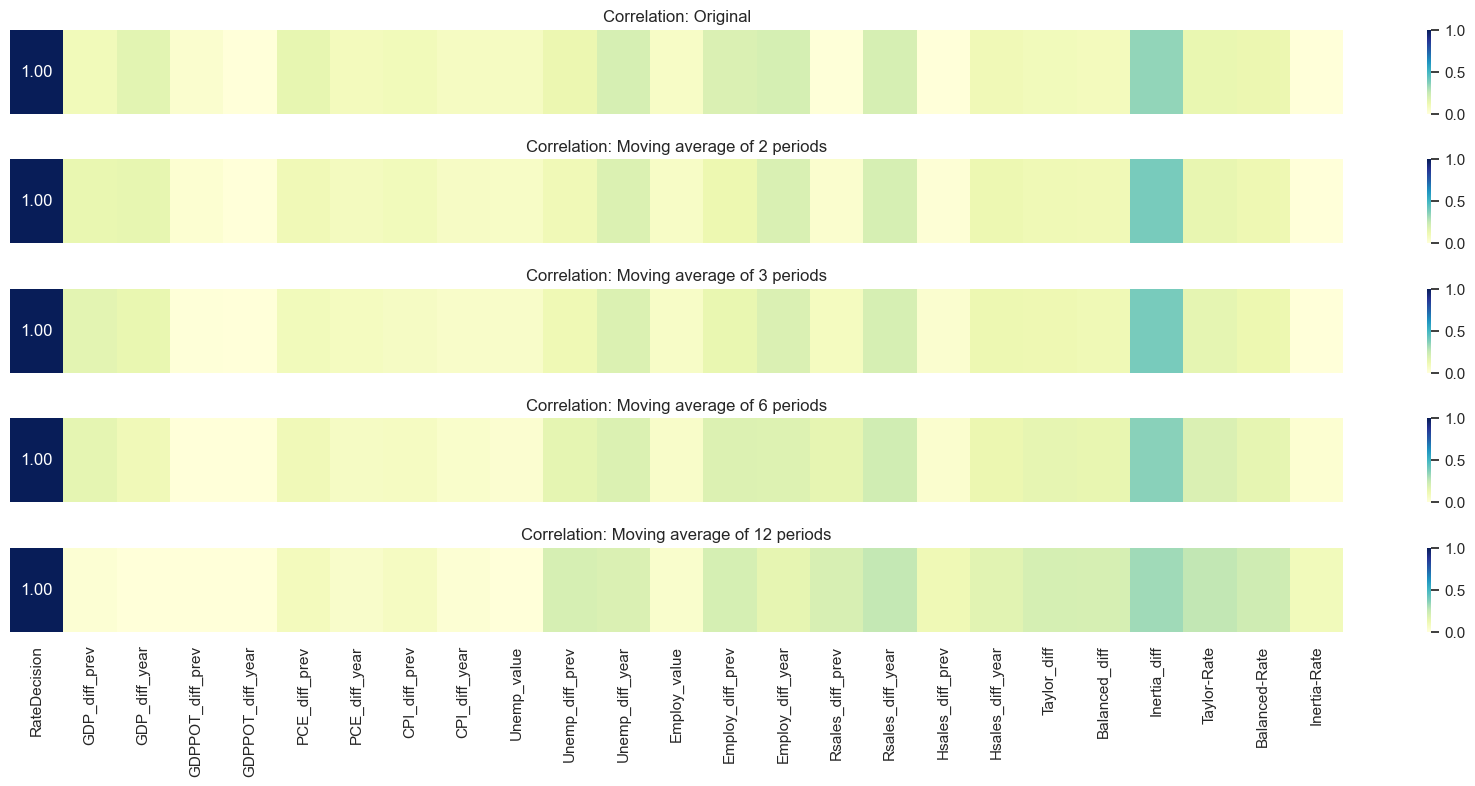

In [15]:
# Moving average (window = 2)
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(17,8))

sns.heatmap(nontext_data[corr_columns].astype(float).corr().iloc[:1], cmap="YlGnBu", annot=True, fmt=".2f", vmin=0, vmax=1, ax=ax1)
ax1.set_title("Correlation: Original")
ax1.set_xticks([])
ax1.set_yticks([])
sns.heatmap(nontext_ma2[corr_columns].astype(float).corr().iloc[:1], cmap="YlGnBu", annot=True, fmt=".2f", vmin=0, vmax=1, ax=ax2)
ax2.set_title("Correlation: Moving average of 2 periods")
ax2.set_xticks([])
ax2.set_yticks([])
sns.heatmap(nontext_ma3[corr_columns].astype(float).corr().iloc[:1], cmap="YlGnBu", annot=True, fmt=".2f", vmin=0, vmax=1, ax=ax3)
ax3.set_title("Correlation: Moving average of 3 periods")
ax3.set_xticks([])
ax3.set_yticks([])
sns.heatmap(nontext_ma6[corr_columns].astype(float).corr().iloc[:1], cmap="YlGnBu", annot=True, fmt=".2f", vmin=0, vmax=1, ax=ax4)
ax4.set_title("Correlation: Moving average of 6 periods")
ax4.set_xticks([])
ax4.set_yticks([])
sns.heatmap(nontext_ma12[corr_columns].astype(float).corr().iloc[:1], cmap="YlGnBu", annot=True, fmt=".2f", vmin=0, vmax=1, ax=ax5)
ax5.set_title("Correlation: Moving average of 12 periods")
ax5.set_yticks([])

fig.tight_layout(pad=1.0)
plt.show()


Not much improvement. The followings can be used:
 * Unemp_diff_prev for previous 3 period
 * Emp_diff_prev for previous 2 period
 * Rsales_diff_year for previous 2 period
 * Hsales_diff_year for previous 12 period
 * Balanced_diff for previous 12 period
 * Intertia_diff for previous 3 period

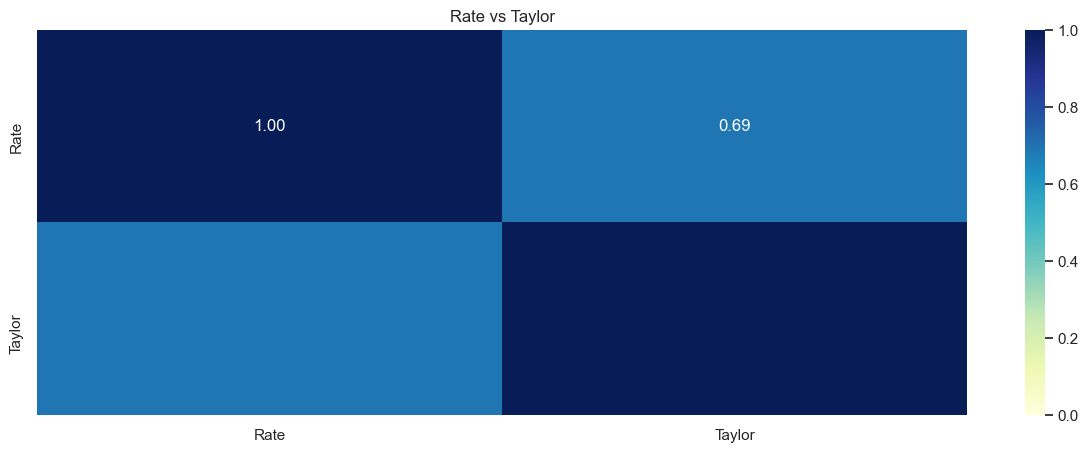

In [18]:
# Correlation between Taylor rule and actual rates are quite high

fig, (ax1) = plt.subplots(1, figsize=(15, 5))

corr_columns = ['Rate', 'Taylor']
sns.heatmap(nontext_data[corr_columns].astype(float).corr(), cmap="YlGnBu", annot=True, fmt=".2f", vmin=0, vmax=1, ax=ax1)
ax1.set_title("Rate vs Taylor")


plt.show()

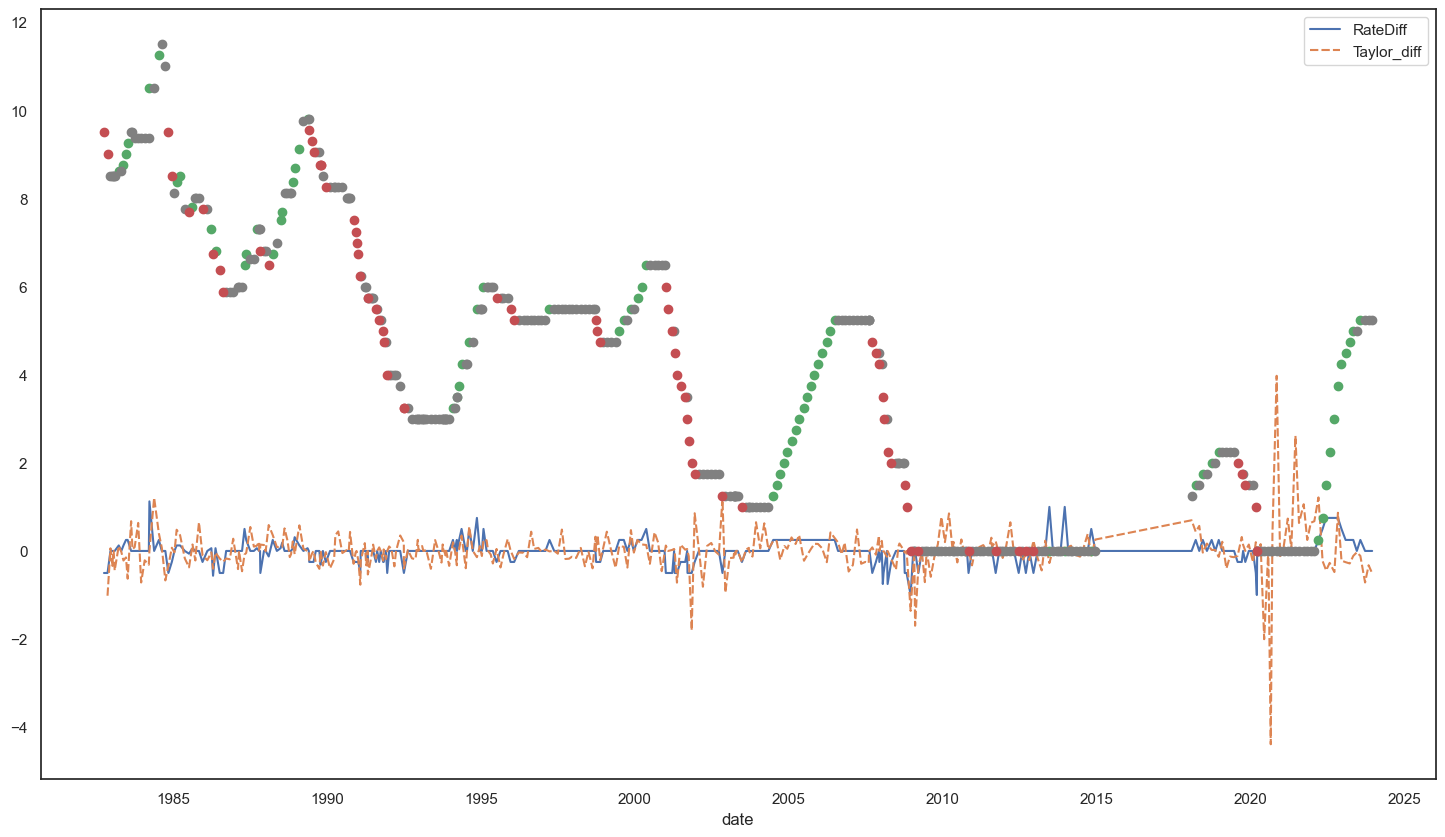

In [14]:
fig, ax = plt.subplots(figsize=(18, 10))
sns.lineplot(data=nontext_data[corr_columns], ax=ax)

decision_raise = nontext_data.loc[nontext_data['RateDecision'] == 1]
decision_hold = nontext_data.loc[nontext_data['RateDecision'] == 0]
decision_lower = nontext_data.loc[nontext_data['RateDecision'] == -1]

ax.plot(decision_raise.index.values, decision_raise['Rate'], 'o', color="g", label="Raise")
ax.plot(decision_hold.index.values, decision_hold['Rate'], 'o', color="grey", label="Hold")
ax.plot(decision_lower.index.values, decision_lower['Rate'], 'o', color="r", label="Lower")


### Check individual columns

In [24]:
def plot_distribution(df, columns):
    for col in tqdm(columns):
        fig, ax = plt.subplots(figsize=(10, 5))
        
        # Create KDE plots
        sns.kdeplot(df[col][(df["RateDecision"] == -1) & (df[col].notnull())], color="Red", shade=True, ax=ax)
        sns.kdeplot(df[col][(df["RateDecision"] == 0) & (df[col].notnull())], color="Blue", shade=True, ax=ax)
        sns.kdeplot(df[col][(df["RateDecision"] == 1) & (df[col].notnull())], color="Green", shade=True, ax=ax)
        
        ax.set_xlabel(col)
        ax.set_ylabel("Frequency")
        ax.set_title("Distribution for " + col, fontsize=14)
        ax.legend(["Lower", "Hold", "Raise"])
        
        # FacetGrid for distribution plots
        g = sns.FacetGrid(df, col='RateDecision', height=3, aspect=1)
        g.map_dataframe(sns.histplot, col, kde=True)
        plt.show()


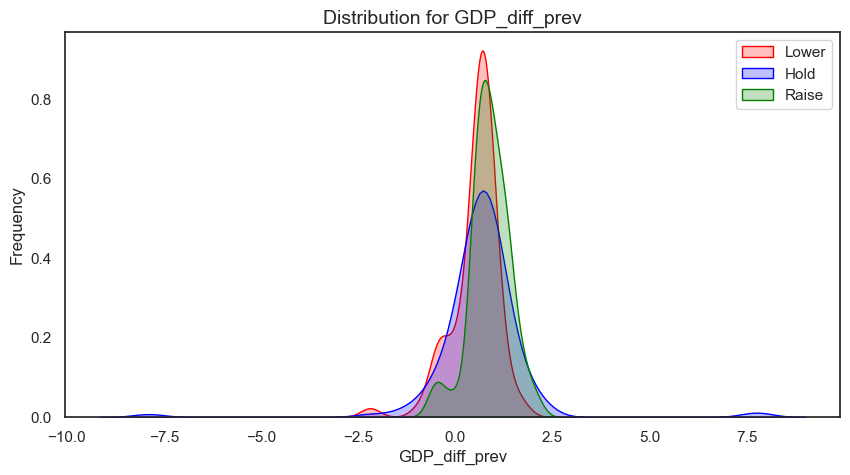

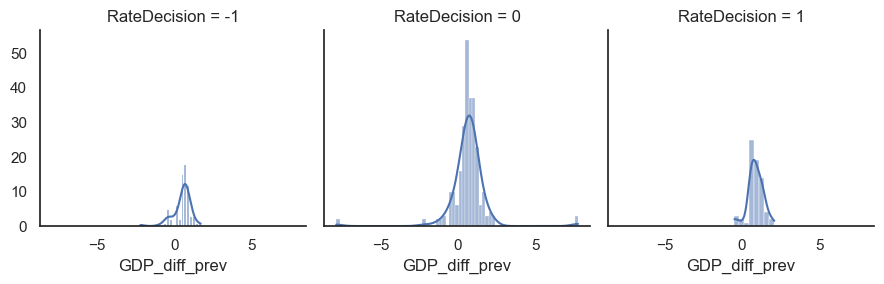

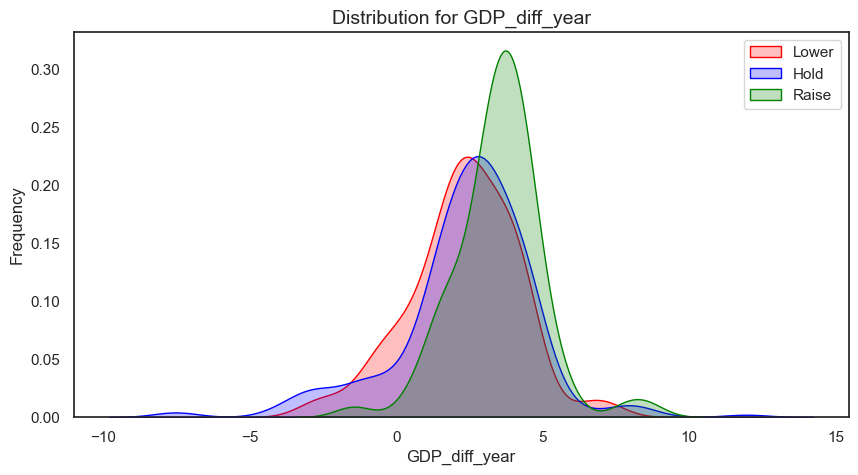

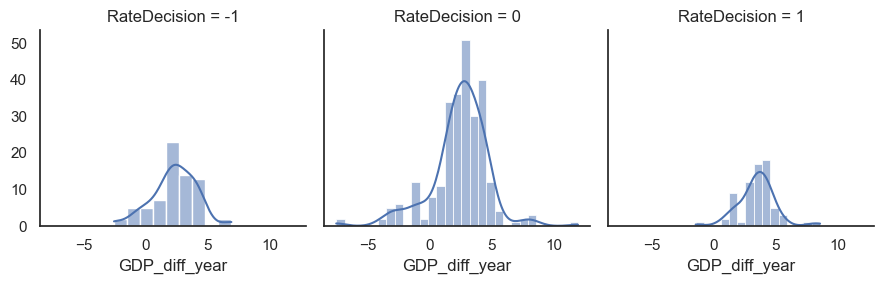

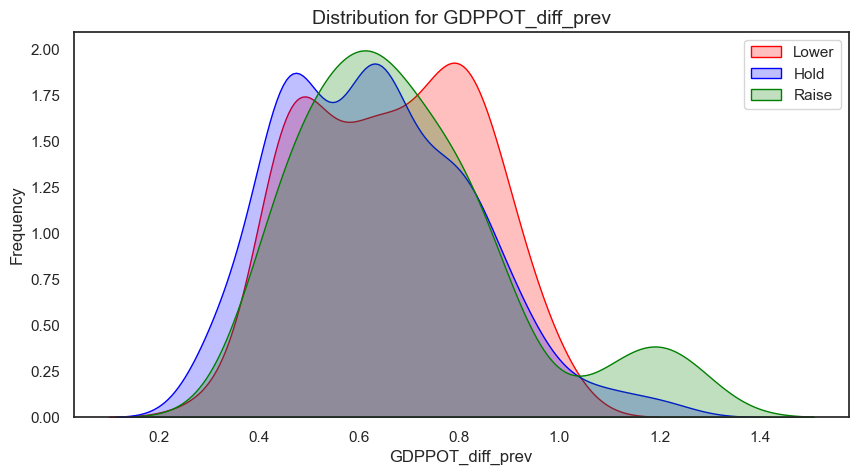

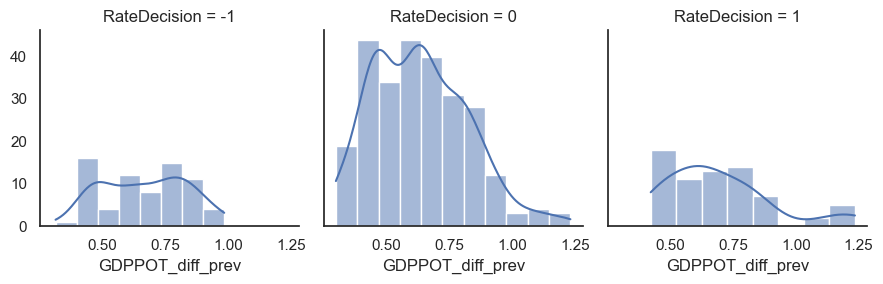

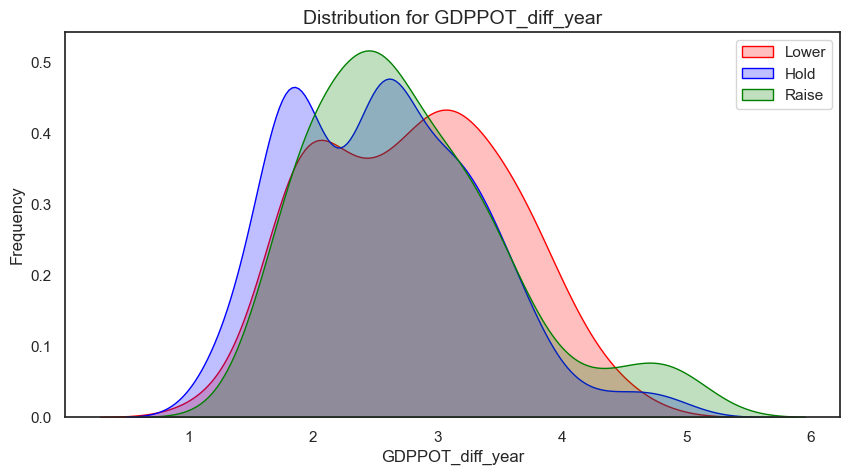

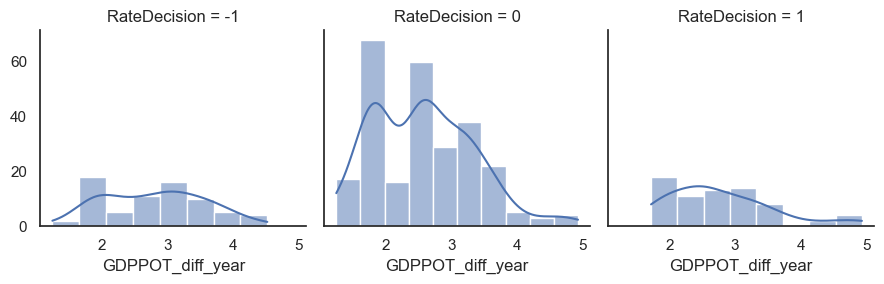

In [25]:
plot_distribution(nontext_data, ["GDP_diff_prev", "GDP_diff_year", "GDPPOT_diff_prev", "GDPPOT_diff_year"])

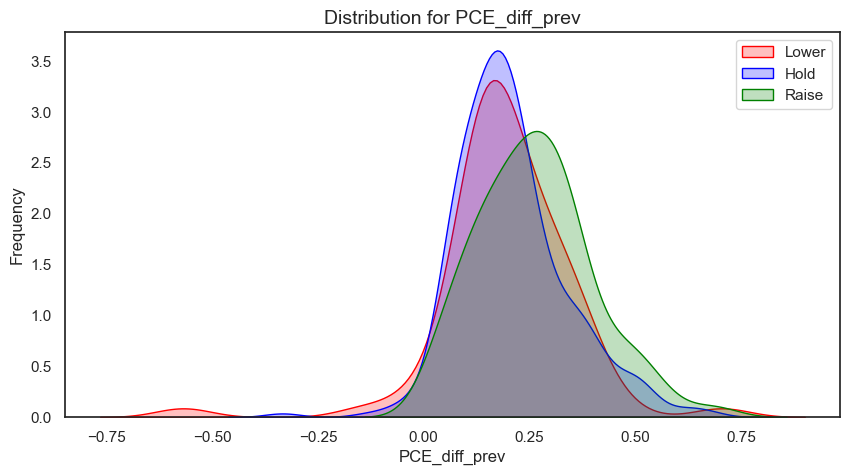

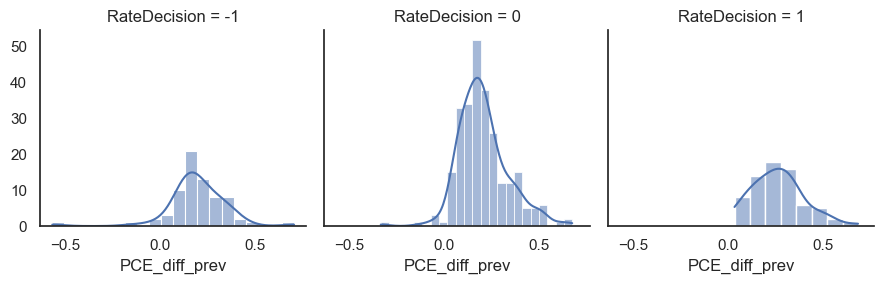

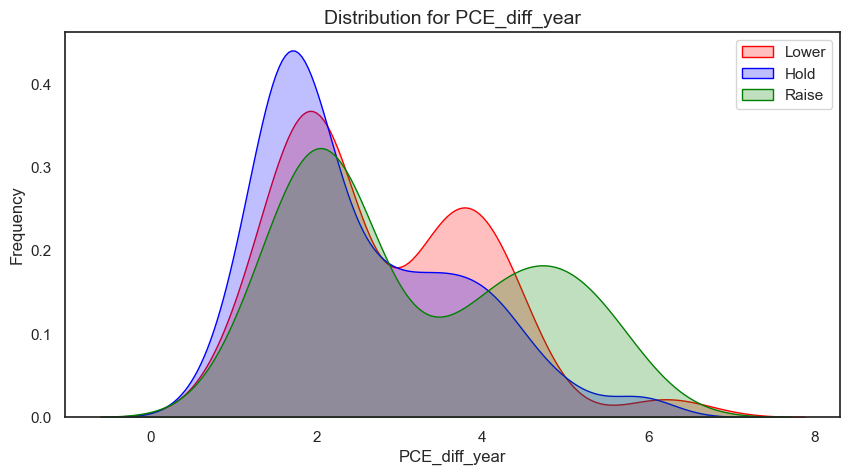

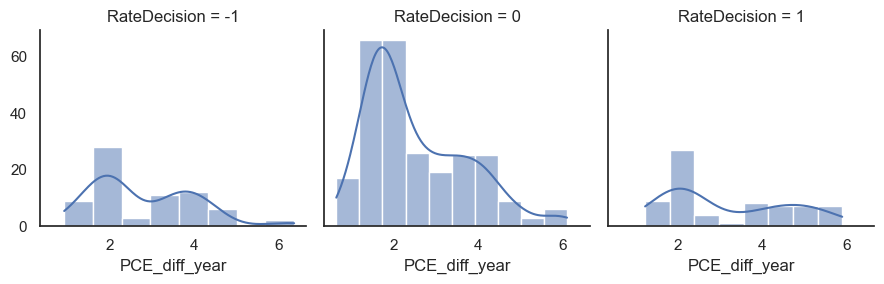

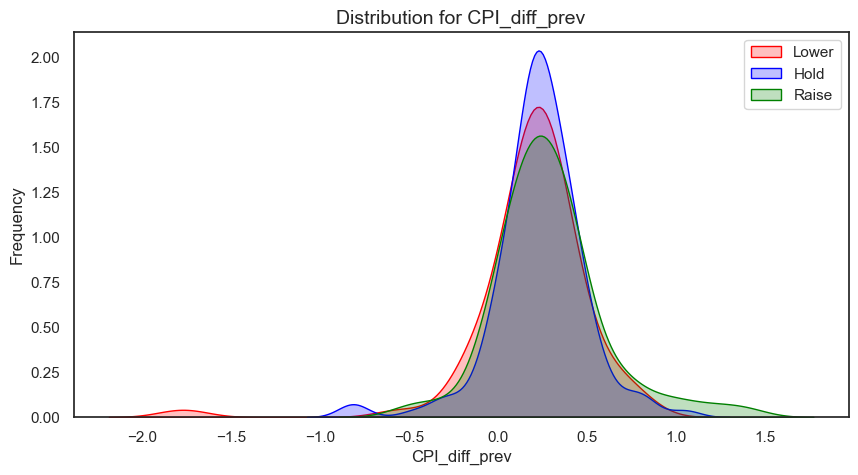

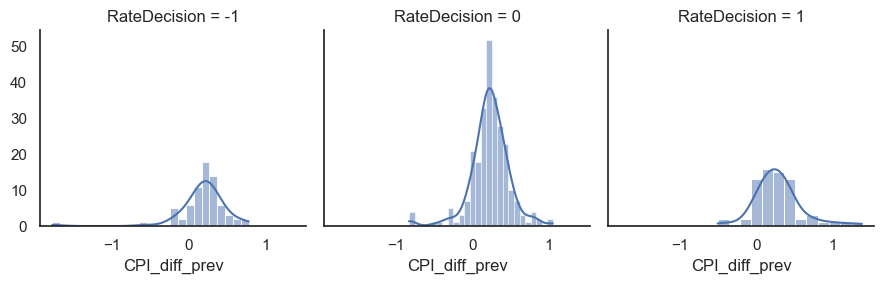

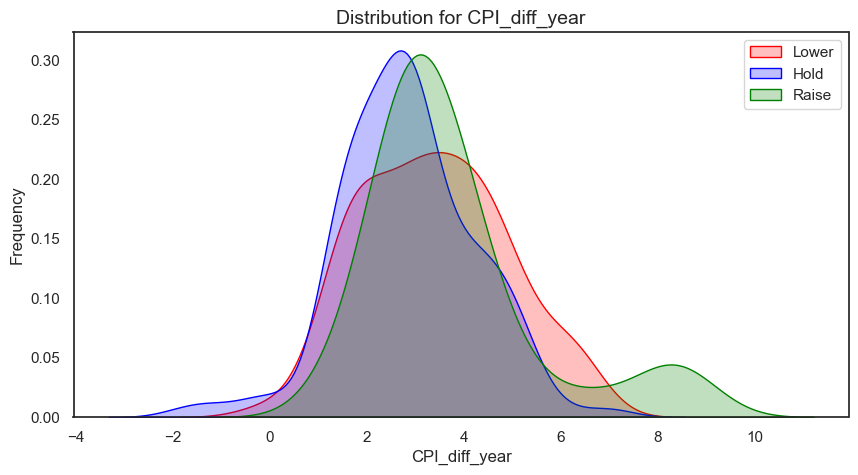

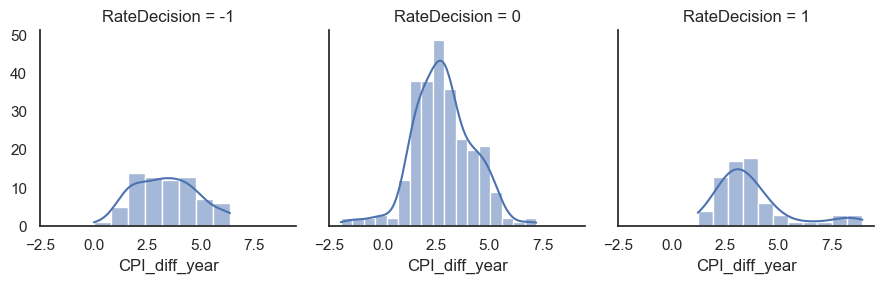

In [26]:
plot_distribution(nontext_data, ["PCE_diff_prev", "PCE_diff_year", "CPI_diff_prev", "CPI_diff_year"])

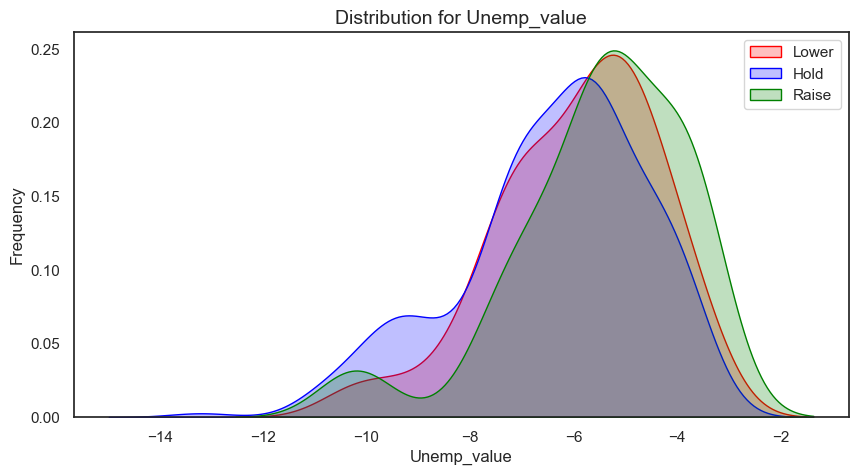

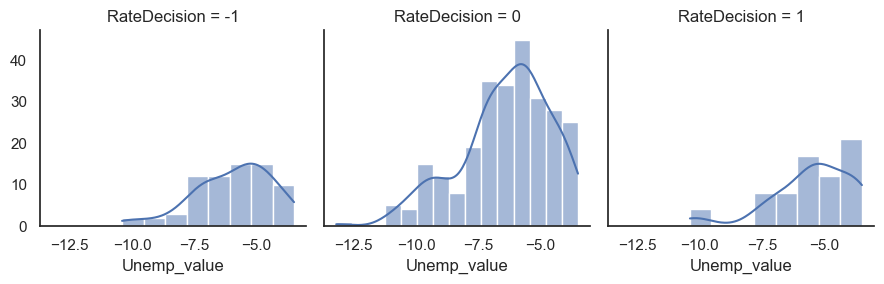

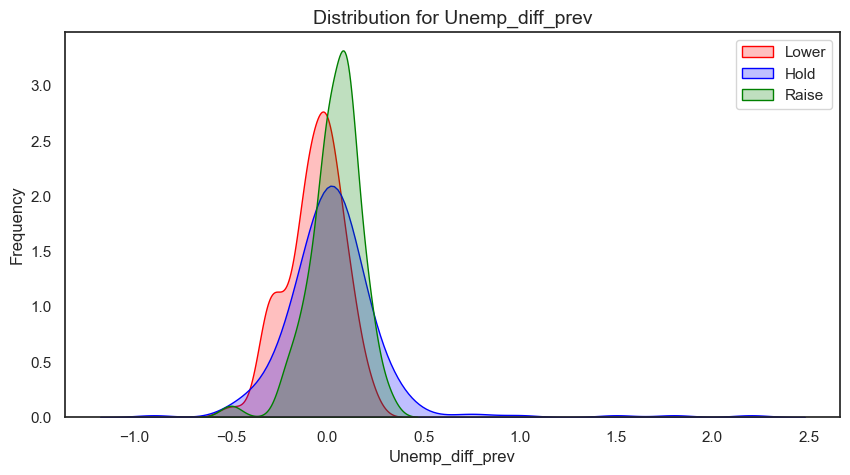

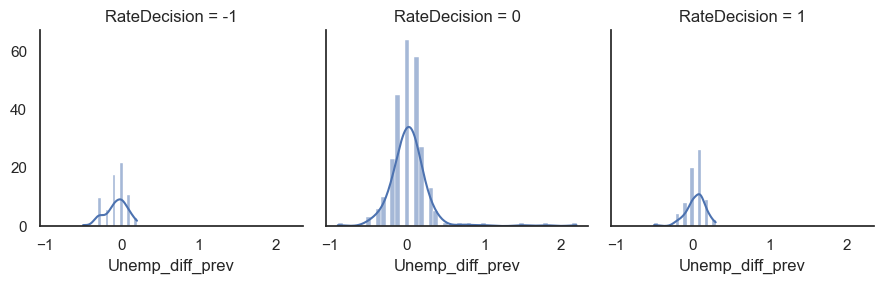

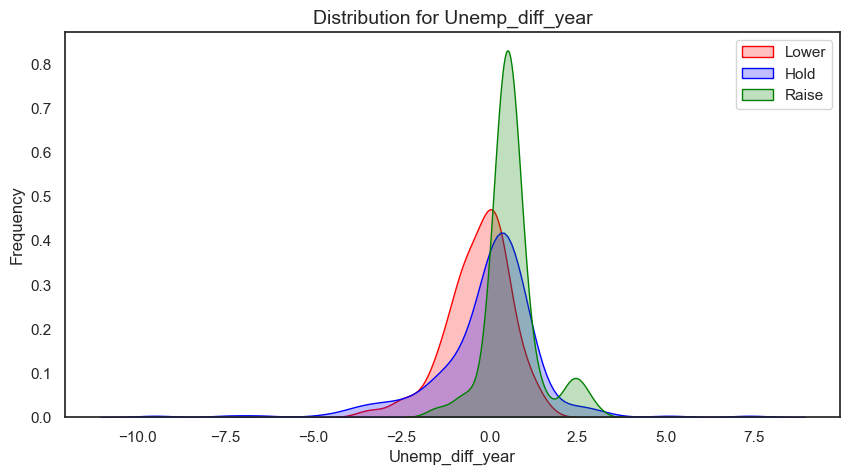

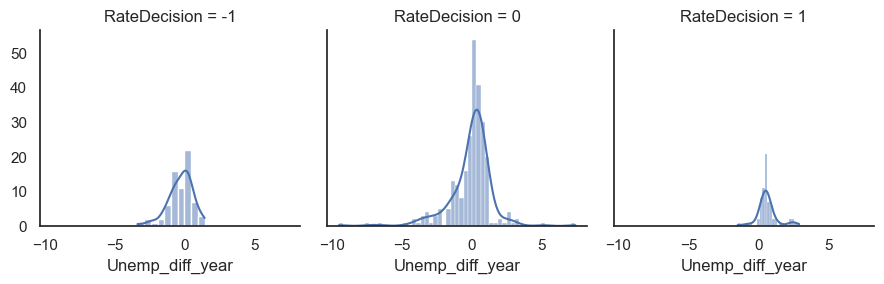

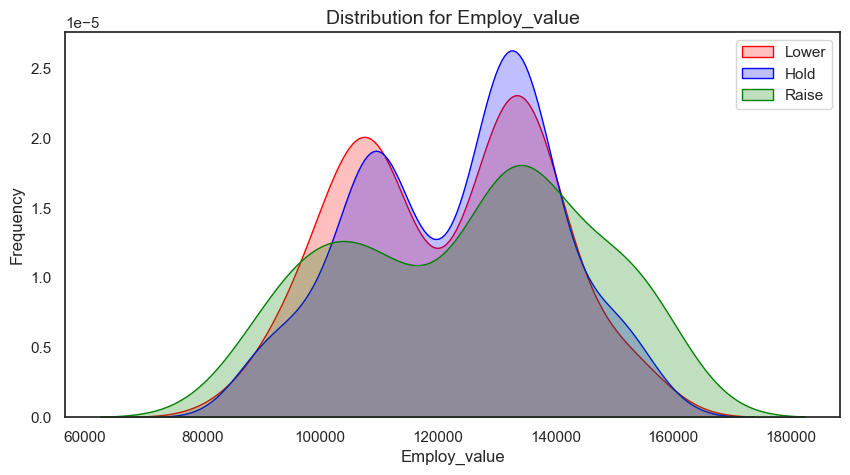

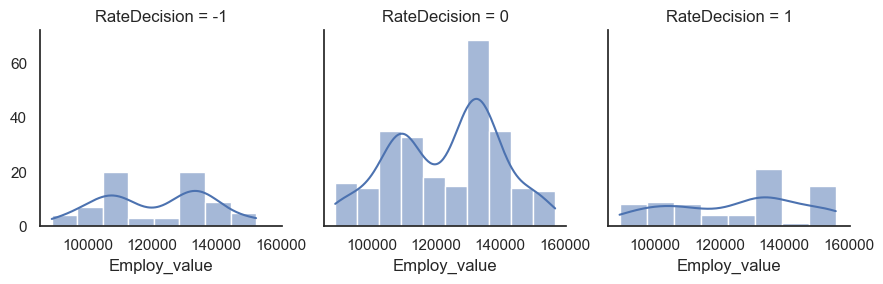

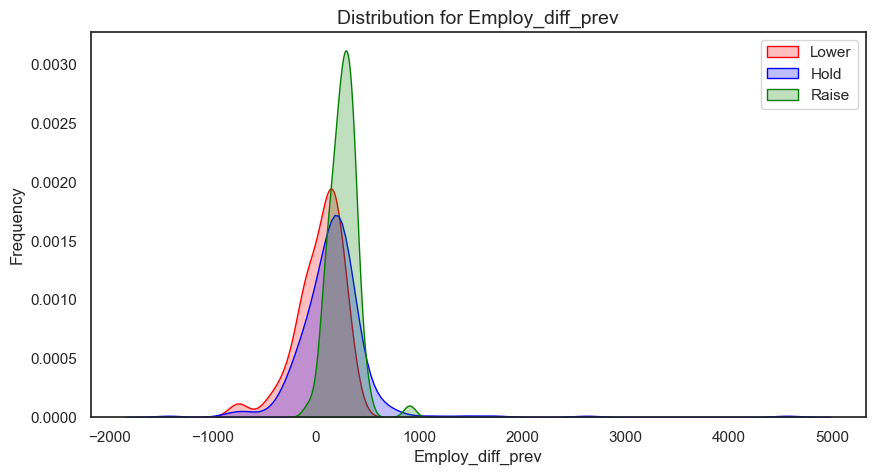

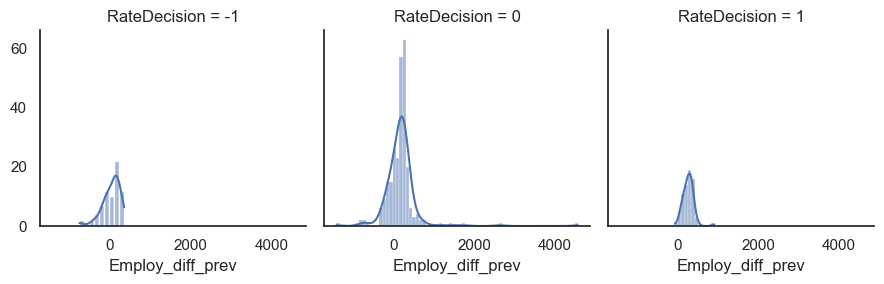

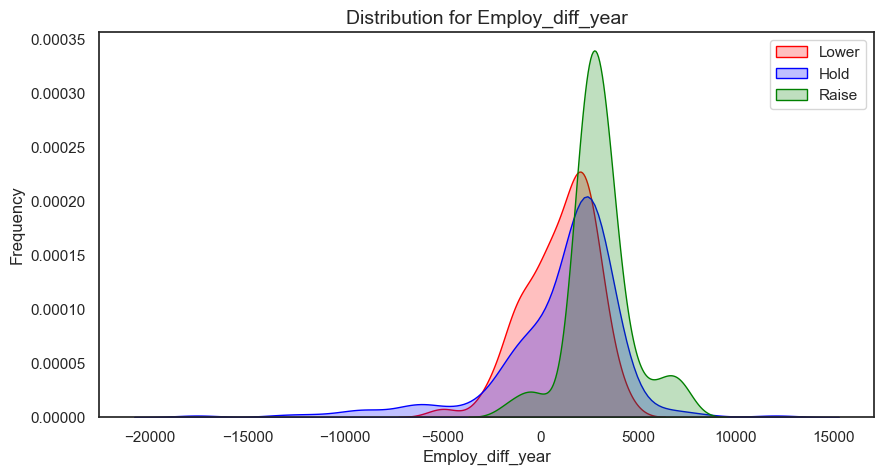

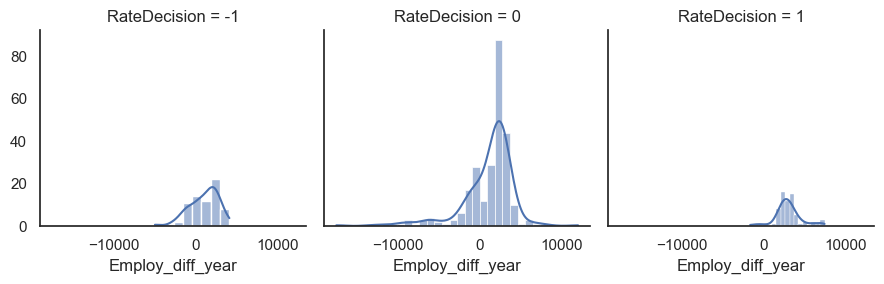

In [27]:
plot_distribution(nontext_data, ["Unemp_value", "Unemp_diff_prev", "Unemp_diff_year", "Employ_value", "Employ_diff_prev", "Employ_diff_year"])

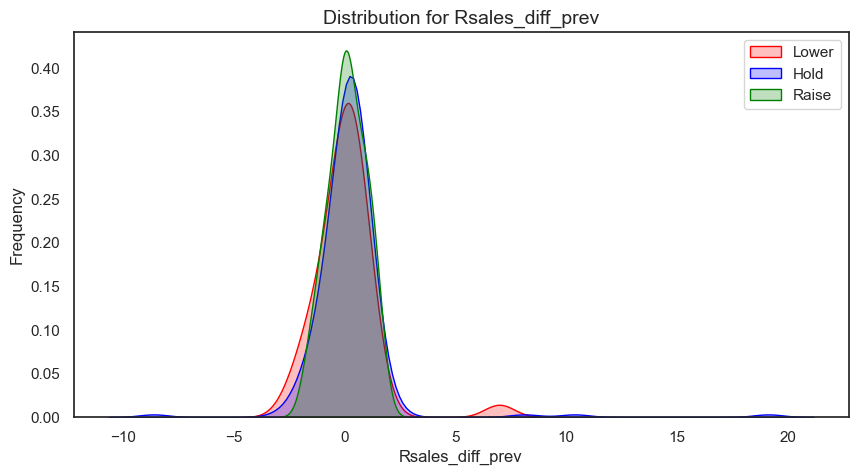

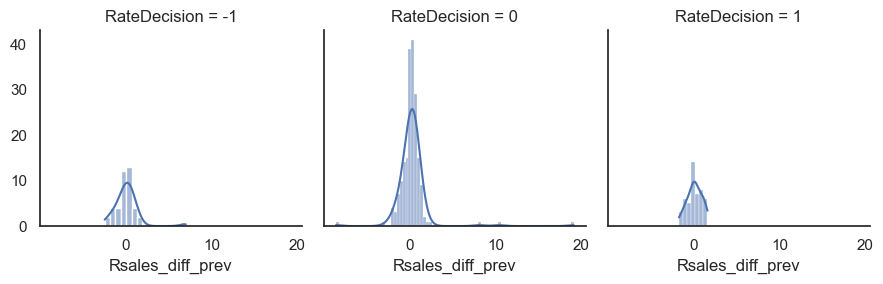

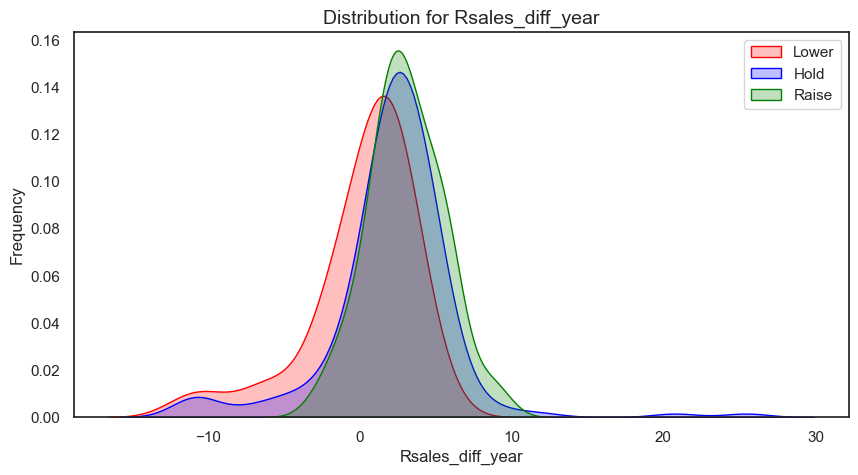

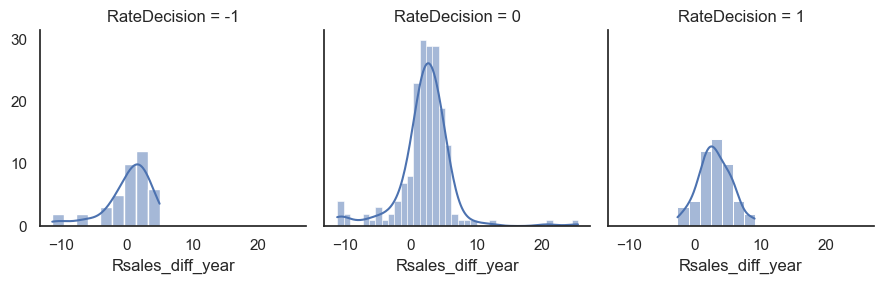

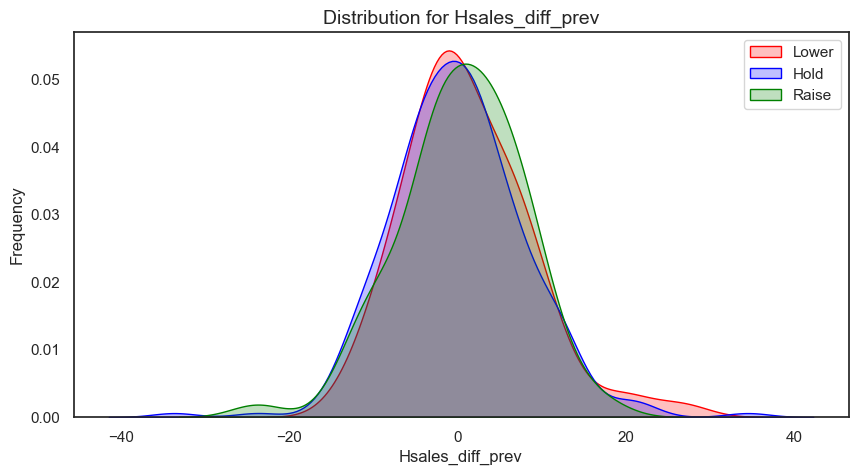

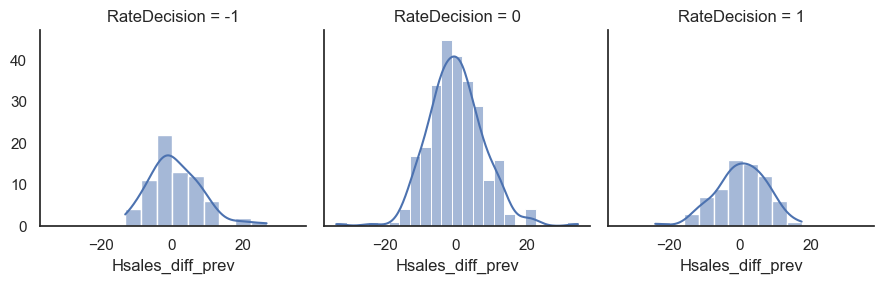

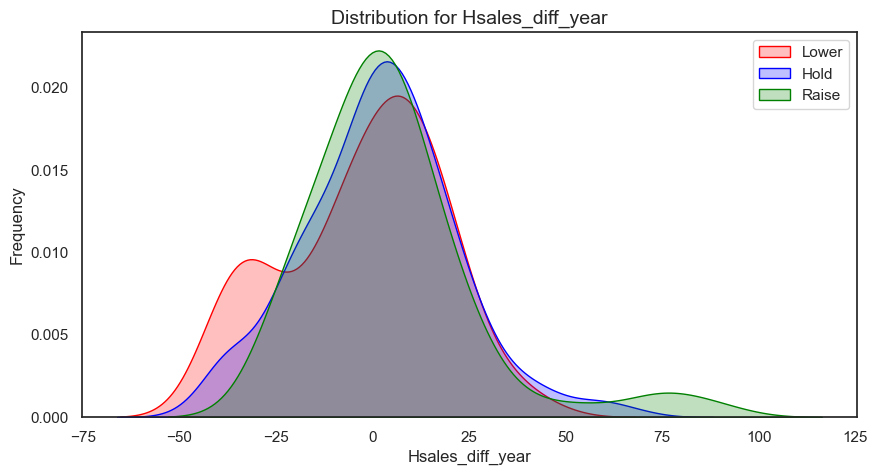

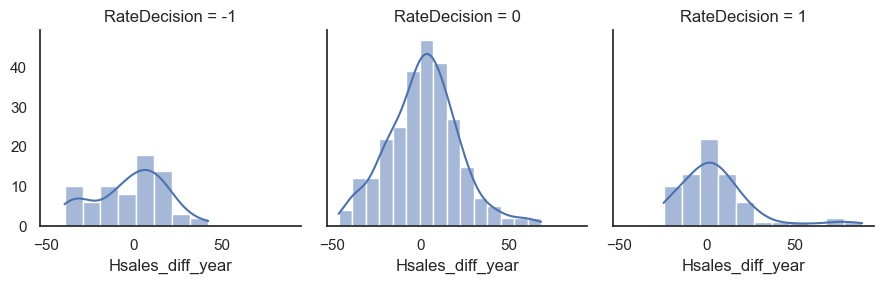

In [29]:
plot_distribution(nontext_data, ["Rsales_diff_prev", "Rsales_diff_year", "Hsales_diff_prev", "Hsales_diff_year"])

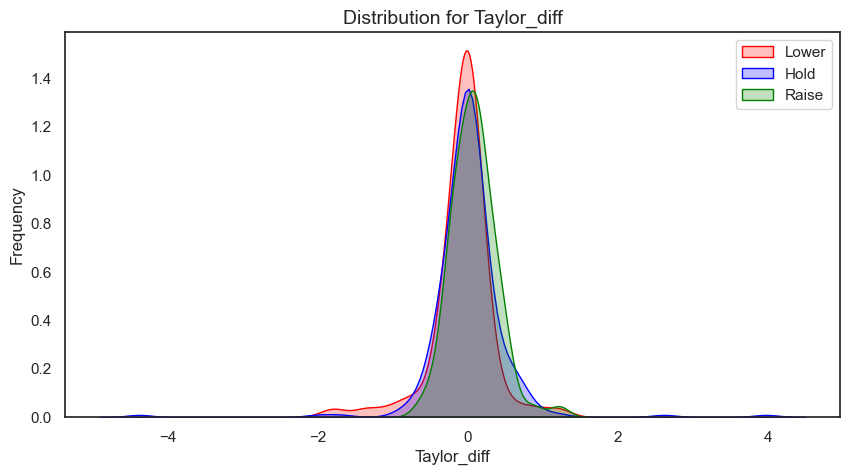

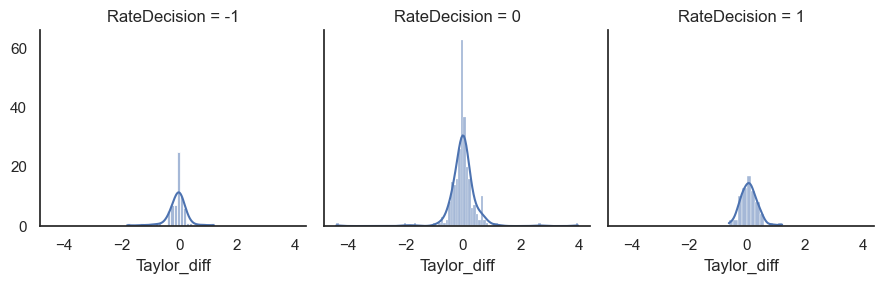

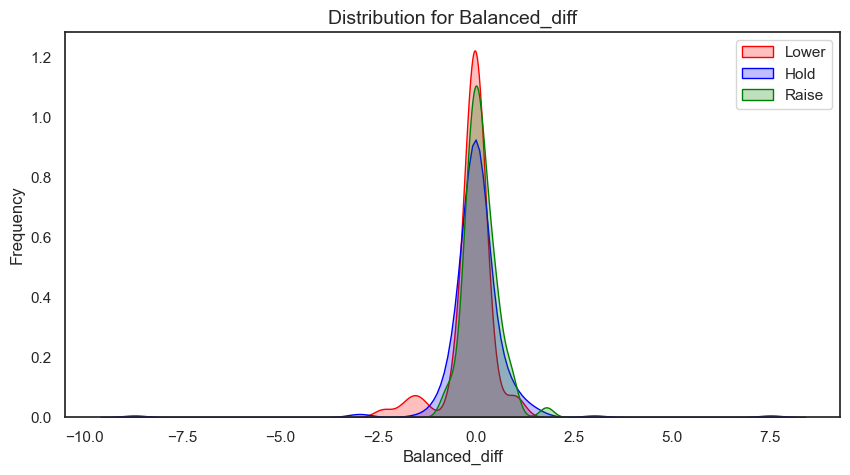

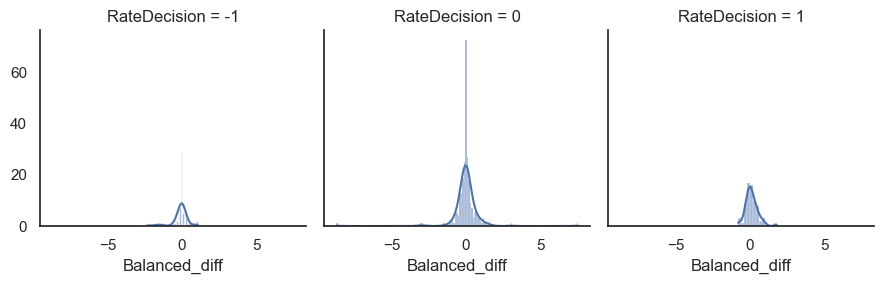

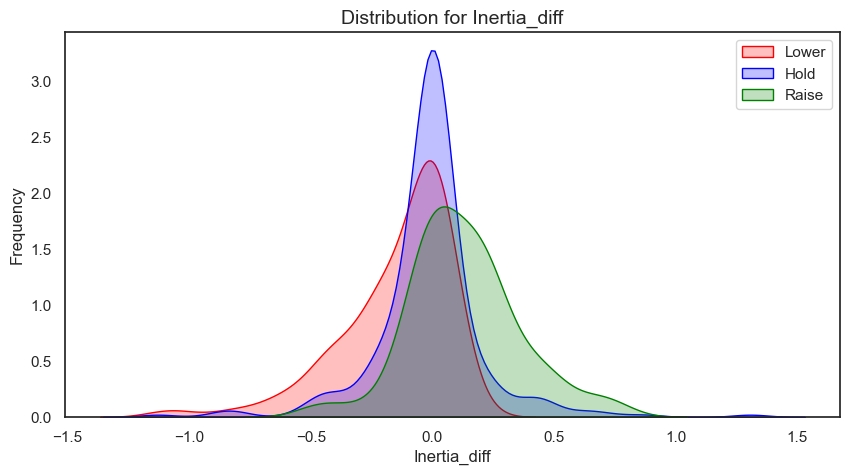

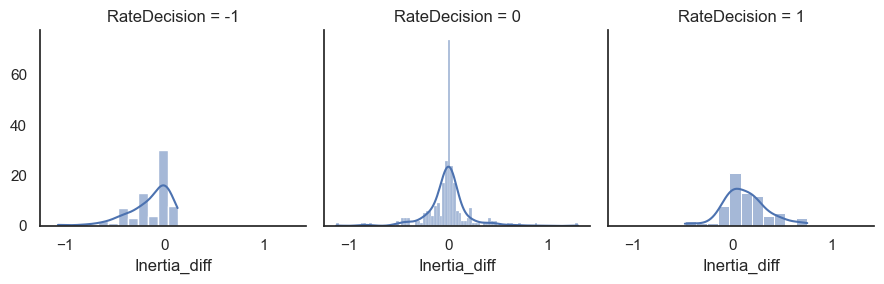

In [30]:
plot_distribution(nontext_data, ["Taylor_diff", "Balanced_diff", "Inertia_diff"])

## Create Training Data Set

In [19]:
nontext_data.head()

,unscheduled,forecast,confcall,ChairPerson,Rate,RateDiff,RateDecision,RateChanged,GDP_date,GDP_value,...,Balanced,Inertia,Taylor-Rate,Balanced-Rate,Inertia-Rate,Taylor_diff,Balanced_diff,Inertia_diff,prev_decision,next_decision
date,,,,,,,,,,,,,,,,,,,,,
1982-10-05,False,False,False,Paul Volcker,9.5,-0.5,-1,1,1982-04-01,7328.912,...,11.567540,6.764869,1.061999,1.567540,-3.235131,NaN,NaN,NaN,<NA>,-1
1982-11-16,False,False,False,Paul Volcker,9.0,-0.5,-1,1,1982-07-01,7300.896,...,9.987419,6.576887,0.545779,0.487419,-2.923113,-1.016220,-1.580121,-0.187982,-1,0
1982-12-21,False,False,False,Paul Volcker,8.5,0.0,0,0,1982-07-01,7300.896,...,10.047278,5.717908,1.605638,1.547278,-2.782092,0.059859,0.059859,-0.858979,-1,0
1983-01-14,False,False,True,Paul Volcker,8.5,0.0,0,0,1982-07-01,7300.896,...,9.707641,5.768854,1.266001,1.207641,-2.731146,-0.339637,-0.339637,0.050946,0,0
1983-01-21,False,False,True,Paul Volcker,8.5,0.0,0,0,1982-07-01,7300.896,...,9.707641,5.768854,1.266001,1.207641,-2.731146,0.000000,0.000000,0.000000,0,0


In [20]:
nontext_data.columns

Index(['unscheduled', 'forecast', 'confcall', 'ChairPerson', 'Rate',
       'RateDiff', 'RateDecision', 'RateChanged', 'GDP_date', 'GDP_value',
       'GDP_diff_prev', 'GDP_diff_year', 'GDPPOT_date', 'GDPPOT_value',
       'GDPPOT_diff_prev', 'GDPPOT_diff_year', 'PCE_date', 'PCE_value',
       'PCE_diff_prev', 'PCE_diff_year', 'CPI_date', 'CPI_value',
       'CPI_diff_prev', 'CPI_diff_year', 'Unemp_date', 'Unemp_value',
       'Unemp_diff_prev', 'Unemp_diff_year', 'Employ_date', 'Employ_value',
       'Employ_diff_prev', 'Employ_diff_year', 'Rsales_date', 'Rsales_value',
       'Rsales_diff_prev', 'Rsales_diff_year', 'Hsales_date', 'Hsales_value',
       'Hsales_diff_prev', 'Hsales_diff_year', 'Taylor', 'Balanced', 'Inertia',
       'Taylor-Rate', 'Balanced-Rate', 'Inertia-Rate', 'Taylor_diff',
       'Balanced_diff', 'Inertia_diff', 'prev_decision', 'next_decision'],
      dtype='object')

In [21]:
# Suponiendo que 'col1', 'col2' y 'col3' son las columnas que deseas seleccionar
columnas_deseadas = ['Rate',
       'RateDiff', 'RateDecision', 'RateChanged', 'GDP_date', 'GDP_value',
       'GDP_diff_prev', 'GDP_diff_year', 'GDPPOT_date', 'GDPPOT_value',
       'GDPPOT_diff_prev', 'GDPPOT_diff_year', 'PCE_date', 'PCE_value',
       'PCE_diff_prev', 'PCE_diff_year', 'CPI_date', 'CPI_value',
       'CPI_diff_prev', 'CPI_diff_year', 'Unemp_date', 'Unemp_value',
       'Unemp_diff_prev', 'Unemp_diff_year', 'Employ_date', 'Employ_value',
       'Employ_diff_prev', 'Employ_diff_year', 'Rsales_date', 'Rsales_value',
       'Rsales_diff_prev', 'Rsales_diff_year', 'Hsales_date', 'Hsales_value',
       'Hsales_diff_prev', 'Hsales_diff_year', 'Taylor', 'Balanced', 'Inertia',
       'Taylor-Rate', 'Balanced-Rate', 'Inertia-Rate', 'Taylor_diff',
       'Balanced_diff', 'Inertia_diff', 'prev_decision', 'next_decision']

variables = [
    'RateDecision',
    'RateDiff',
    'prev_decision',
    'Employ_diff_year',
    'Rsales_diff_year',
    'Unemp_diff_year',
    'Employ_diff_prev',
    'GDP_diff_year',
    'PCE_diff_prev',
    'Unemp_diff_prev',
    'Hsales_diff_year',
    'GDP_diff_prev',
    'Taylor'
]

# Crear un nuevo DataFrame seleccionando el subconjunto de columnas
nontext_train_small = nontext_data[variables]


In [22]:

nontext_train_small.rename(columns={'RateDecision': 'target'}, inplace=True)

C:\Users\luisl\AppData\Local\Temp\ipykernel_2440\14392617.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nontext_train_small.rename(columns={'RateDecision': 'target'}, inplace=True)


In [23]:
nontext_train_small.isnull().sum()

target                0
RateDiff              0
prev_decision         1
Employ_diff_year      0
Rsales_diff_year    129
Unemp_diff_year       0
Employ_diff_prev      0
GDP_diff_year         0
PCE_diff_prev         0
Unemp_diff_prev       0
Hsales_diff_year      0
GDP_diff_prev         0
Taylor                0
dtype: int64

In [24]:
# Large dataset to include all the latest figures plus 3 months rolling average

latest_columns = ['RateDecision', 'prev_decision',
                  'GDP_diff_prev', 'GDP_diff_year', 'GDPPOT_diff_prev', 'GDPPOT_diff_year',
                  'PCE_diff_prev', 'PCE_diff_year', 'CPI_diff_prev', 'CPI_diff_year', 
                  'Unemp_value', 'Unemp_diff_prev', 'Unemp_diff_year',
                  'Employ_value', 'Employ_diff_prev', 'Employ_diff_year',
                  'Rsales_diff_prev', 'Rsales_diff_year', 'Hsales_diff_prev', 'Hsales_diff_year',
                  'Taylor-Rate', 'Balanced-Rate', 'Inertia-Rate', 'Taylor_diff', 'Balanced_diff', 'Inertia_diff']

ma3_columns = ['GDP_diff_prev', 'GDP_diff_year', 'GDPPOT_diff_prev', 'GDPPOT_diff_year',
               'PCE_diff_prev', 'PCE_diff_year', 'CPI_diff_prev', 'CPI_diff_year', 
               'Unemp_value', 'Unemp_diff_prev', 'Unemp_diff_year',
               'Employ_value', 'Employ_diff_prev', 'Employ_diff_year',
               'Rsales_diff_prev', 'Rsales_diff_year', 'Hsales_diff_prev', 'Hsales_diff_year',
               'Taylor-Rate', 'Balanced-Rate', 'Inertia-Rate', 'Taylor_diff', 'Balanced_diff', 'Inertia_diff']

nontext_train_large = pd.concat([nontext_data[latest_columns], nontext_ma3[ma3_columns].add_suffix('_ma3')], axis=1)
nontext_train_large.rename(columns={'RateDecision': 'target'}, inplace=True)
print(nontext_data[latest_columns].shape)
print(nontext_ma3[ma3_columns].shape)
print(nontext_train_large.shape)

(403, 26)
(403, 24)
(403, 50)


In [25]:
nontext_train_large.isnull().sum()

target                    0
prev_decision             1
GDP_diff_prev             0
GDP_diff_year             0
GDPPOT_diff_prev          0
GDPPOT_diff_year          0
PCE_diff_prev             0
PCE_diff_year             0
CPI_diff_prev             0
CPI_diff_year             0
Unemp_value               0
Unemp_diff_prev           0
Unemp_diff_year           0
Employ_value              0
Employ_diff_prev          0
Employ_diff_year          0
Rsales_diff_prev        117
Rsales_diff_year        129
Hsales_diff_prev          0
Hsales_diff_year          0
Taylor-Rate               0
Balanced-Rate             0
Inertia-Rate              0
Taylor_diff               1
Balanced_diff             1
Inertia_diff              1
GDP_diff_prev_ma3         0
GDP_diff_year_ma3         0
GDPPOT_diff_prev_ma3      0
GDPPOT_diff_year_ma3      0
PCE_diff_prev_ma3         0
PCE_diff_year_ma3         0
CPI_diff_prev_ma3         0
CPI_diff_year_ma3         0
Unemp_value_ma3           0
Unemp_diff_prev_ma3 

### Missing Values

In [26]:
# As most likely the decision is 0 (hold), fill prev_decision of the first row
nontext_train_small['prev_decision'].fillna(0, inplace=True)
nontext_train_large['prev_decision'].fillna(0, inplace=True)

C:\Users\luisl\AppData\Local\Temp\ipykernel_2440\3104963703.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nontext_train_small['prev_decision'].fillna(0, inplace=True)


(0.0, 400.0)

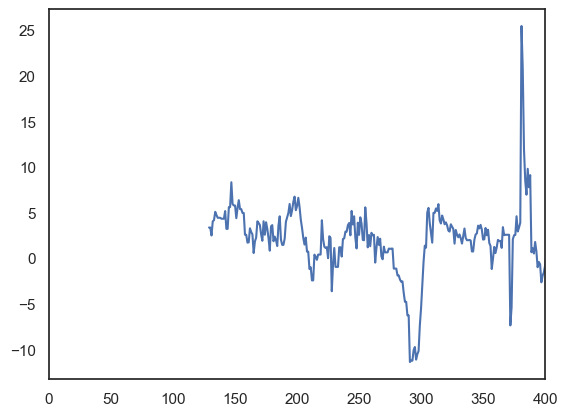

In [27]:
ax = sns.lineplot(data=nontext_train_small['Rsales_diff_year'].values)
ax.set_xlim(0, 400)

(0.0, 400.0)

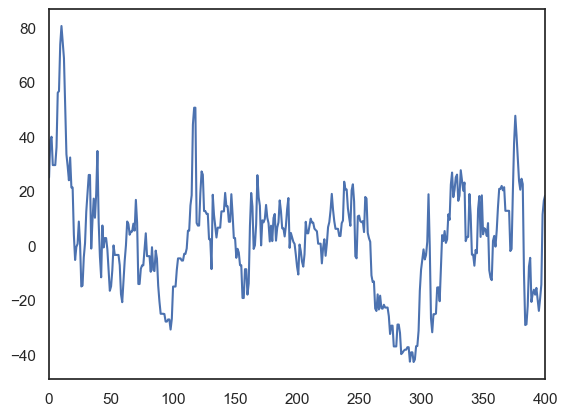

In [28]:
ax = sns.lineplot(data=nontext_ma2['Hsales_diff_year'].values)
ax.set_xlim(0, 400)

In [30]:
nontext_train_small['Rsales_diff_year'].fillna(nontext_train_small['Rsales_diff_year'].mean(), inplace=True)

C:\Users\luisl\AppData\Local\Temp\ipykernel_2440\3744878521.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nontext_train_small['Rsales_diff_year'].fillna(nontext_train_small['Rsales_diff_year'].mean(), inplace=True)


In [29]:
# Retail sales growth ratio is difficult to estimate. Though it is not ideal, simply use the average
nontext_train_small['Rsales_diff_year'].fillna(nontext_train_small['Rsales_diff_year'].mean(), inplace=True)
#nontext_train_large['Rsales_diff_prev'].fillna(nontext_train_large['Rsales_diff_prev'].mean(), inplace=True)
#nontext_train_large['Rsales_diff_year'].fillna(nontext_train_large['Rsales_diff_year'].mean(), inplace=True)

nontext_train_small['Inertia_diff'].fillna(nontext_train_small['Inertia_diff'].mean(), inplace=True)
nontext_train_small['Balanced_diff'].fillna(nontext_train_small['Balanced_diff'].mean(), inplace=True)
nontext_train_large['Inertia_diff'].fillna(nontext_train_large['Inertia_diff'].mean(), inplace=True)
nontext_train_large['Balanced_diff'].fillna(nontext_train_large['Balanced_diff'].mean(), inplace=True)
nontext_train_large['Taylor_diff'].fillna(nontext_train_large['Taylor_diff'].mean(), inplace=True)

nontext_train_large['Rsales_diff_prev_ma3'].fillna(nontext_train_large['Rsales_diff_prev_ma3'].mean(), inplace=True)
nontext_train_large['Rsales_diff_year_ma3'].fillna(nontext_train_large['Rsales_diff_year_ma3'].mean(), inplace=True)

nontext_train_large['Inertia_diff_ma3'].fillna(nontext_train_large['Inertia_diff_ma3'].mean(), inplace=True)
nontext_train_large['Balanced_diff_ma3'].fillna(nontext_train_large['Balanced_diff_ma3'].mean(), inplace=True)
nontext_train_large['Taylor_diff_ma3'].fillna(nontext_train_large['Taylor_diff_ma3'].mean(), inplace=True)
nontext_train_large['Inertia-Rate_ma3'].fillna(nontext_train_large['Inertia-Rate_ma3'].mean(), inplace=True)
nontext_train_large['Balanced-Rate_ma3'].fillna(nontext_train_large['Balanced-Rate_ma3'].mean(), inplace=True)
nontext_train_large['Taylor-Rate_ma3'].fillna(nontext_train_large['Taylor-Rate_ma3'].mean(), inplace=True)


C:\Users\luisl\AppData\Local\Temp\ipykernel_2440\429270142.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nontext_train_small['Rsales_diff_year'].fillna(nontext_train_small['Rsales_diff_year'].mean(), inplace=True)


KeyError: 'Inertia_diff'

In [31]:
nontext_train_small.isnull().sum()

target              0
RateDiff            0
prev_decision       0
Employ_diff_year    0
Rsales_diff_year    0
Unemp_diff_year     0
Employ_diff_prev    0
GDP_diff_year       0
PCE_diff_prev       0
Unemp_diff_prev     0
Hsales_diff_year    0
GDP_diff_prev       0
Taylor              0
dtype: int64

In [42]:
nontext_train_large.isnull().sum()

target                  0
prev_decision           0
GDP_diff_prev           0
GDP_diff_year           0
GDPPOT_diff_prev        0
GDPPOT_diff_year        0
PCE_diff_prev           0
PCE_diff_year           0
CPI_diff_prev           0
CPI_diff_year           0
Unemp_value             0
Unemp_diff_prev         0
Unemp_diff_year         0
Employ_value            0
Employ_diff_prev        0
Employ_diff_year        0
Rsales_diff_prev        0
Rsales_diff_year        0
Hsales_diff_prev        0
Hsales_diff_year        0
Taylor-Rate             0
Balanced-Rate           0
Inertia-Rate            0
Taylor_diff             0
Balanced_diff           0
Inertia_diff            0
GDP_diff_prev_ma3       0
GDP_diff_year_ma3       0
GDPPOT_diff_prev_ma3    0
GDPPOT_diff_year_ma3    0
PCE_diff_prev_ma3       0
PCE_diff_year_ma3       0
CPI_diff_prev_ma3       0
CPI_diff_year_ma3       0
Unemp_value_ma3         0
Unemp_diff_prev_ma3     0
Unemp_diff_year_ma3     0
Employ_value_ma3        0
Employ_diff_

### One-hot encoding

In [43]:
# nontext_train['Lower'] = nontext_train['RateDecision'].apply(lambda x: 1 if x == -1 else 0)
# nontext_train['Hold'] = nontext_train['RateDecision'].apply(lambda x: 1 if x == 0 else 0)
# nontext_train['Raise'] = nontext_train['RateDecision'].apply(lambda x: 1 if x == 1 else 0)
# nontext_train

# Save Data

In [32]:
def save_data(df, file_name, dir_name='../data/train_data/'):
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)
        
    # Save results to a picke file
    file = open(dir_name + file_name + '.pickle', 'wb')
    pickle.dump(df, file)
    file.close()

    # Save results to a csv file
    df.to_csv(dir_name + file_name + '.csv', index=True)

In [33]:
# Save non-text data
save_data(nontext_train_small, 'nontext_train_small')
save_data(nontext_train_large, 'nontext_train_large')